In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.linalg as lin

import os
from scipy.io import loadmat, savemat

from data_processing import confiy, plot_fft, generate_multi_sin_signal, add_gaussian_noise

from systems import scaled_system, simulate_scaled_system, silverbox_sin

from utils import save_data, load_data

from SI_metrics import display_equation

*****INPUT DATA*****

In [2]:
N_train, N_val, N_test, N_arrow = 200000, 20000, 50000, 50000

u_arrow = confiy(np.random.normal(0,1.8,(N_arrow,1)))
u_train = np.random.normal(0,1,(N_train,1))

# multi sin test set
n, f_min, f_max, Ts = 1400, 1, 200, 0.5  
A = np.ptp(u_train)/2
u_test, _, _ = generate_multi_sin_signal(n, f_min, f_max, A, N_test, Ts)

u = np.r_[u_arrow, u_train, u_test]

*****GENERATE STATE INFO*****

In [3]:
th = np.array([-2,  -1.5,  2.5, 1.5])# final_arrowset

Ts = 0.5 # sampling time of input
x0 = np.array([0,0])
original_system = silverbox_sin

x_us, u_us = simulate_scaled_system(x0, u, original_system, th, Ts)

*****DATA INFO*****

In [4]:
print("x1 -> mean:  {}, std: {}".format(np.mean(x_us[:,0]),np.std(x_us[:,0])))
print("   -> range: {}".format(np.ptp(x_us[:,0])))
print("x2 -> mean:  {}, std: {}".format(np.mean(x_us[:,1]),np.std(x_us[:,1])))
print("   -> range: {}".format(np.ptp(x_us[:,1])))
print("u  -> mean:  {}, std: {}".format(np.mean(u_us),np.std(u_us)))
print("   -> range: {}".format(np.ptp(u_us)))

# plot_fft(x_us[:,0], Ts)
# plot_fft(x_us[:,1], Ts)
# plot_fft(u_us, Ts)

x1 -> mean:  -0.0025186347154603347, std: 1.318625233720937
   -> range: 17.916878845950563
x2 -> mean:  -3.217032478193227e-06, std: 1.7383629388769632
   -> range: 27.275426432532928
u  -> mean:  -0.0010006723811973757, std: 1.000299880651825
   -> range: 12.012724567252754


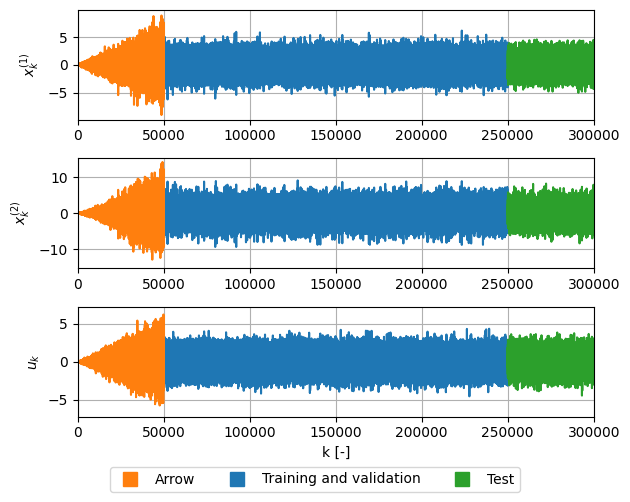

In [5]:
nprint = x_us.shape[0]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Plot on each subplot
ax1.plot(np.arange(N_arrow,N_arrow+N_train,1),x_us[N_arrow:N_arrow+N_train,0])         # train
ax1.plot(np.arange(0,N_arrow,1),x_us[:N_arrow,0])                                      # arrow
ax1.plot(np.arange(N_arrow+N_train,nprint,1),x_us[-N_test:,0])                         # test
ax1.set_ylabel("$x^{(1)}_{k}$")
ax1.set_xlim([0, nprint])
ax1.set_ylim([-np.max([np.min(x_us[:,0]), np.max(x_us[:,0])])-1, np.max([np.min(x_us[:,0]), np.max(x_us[:,0])])+1])
ax1.grid()

ax2.plot(np.arange(N_arrow,N_arrow+N_train,1),x_us[N_arrow:N_arrow+N_train,1])         # train
ax2.plot(np.arange(0,N_arrow,1),x_us[:N_arrow,1])                                      # arrow
ax2.plot(np.arange(N_arrow+N_train,nprint,1),x_us[-N_test:,1])                         # test
ax2.set_ylabel("$x^{(2)}_{k}$")
ax2.set_xlim([0, nprint])
ax2.set_ylim([-np.max([np.min(x_us[:,1]), np.max(x_us[:,1])])-1, np.max([np.min(x_us[:,1]), np.max(x_us[:,1])])+1])
ax2.grid()

ax3.plot(np.arange(N_arrow,N_arrow+N_train,1),u_us[N_arrow:N_arrow+N_train])         # train
ax3.plot(np.arange(0,N_arrow,1),u_us[:N_arrow])                                      # arrow
ax3.plot(np.arange(N_arrow+N_train,nprint,1),u_us[-N_test:])                         # test
ax3.set_ylabel("$u_{k}$")
ax3.set_xlim([0, nprint])
ax3.set_ylim([-np.max([np.min(u_us), np.max(u_us)])-1, np.max([np.min(u_us), np.max(u_us)])+1])
ax3.set_xlabel("k [-]")
ax3.grid()

# Adjust layout (optional)
plt.tight_layout()

custom_lines = [
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label='Arrow'),
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='Training and validation'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='Test')
]

# Add a single legend below all subplots with colored squares
fig.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# plt.savefig('unscaled_data.png', dpi=450, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()

In [6]:
# check if solveable with LSQ
input = x_us[50000:-1,:]
output = x_us[50001:,:]

u_input = u_us[50000:-1]
Theta = np.c_[input[:,0], input[:,1], u_input, np.sin(input[:,0])]

us_coeff, _, _, _ = lin.lstsq(Theta, output)
print("LSTSQ: \n{}\n\ntrue coeff: {}\n".format(us_coeff, th))

_, s, _ = lin.svd(Theta[60000:70000,:])
print("eigval: {}\n".format(s))

labels = ["x_0[k]","x_1[k]","u_0[k]","sin(x_0[k])"]
eq_us = display_equation(us_coeff.flatten("F"), labels, threshold=0.01, precision=6)

LSTSQ: 
[[ 1.00000000e+00 -1.00000000e+00]
 [ 5.00000000e-01  2.50000000e-01]
 [ 4.58617519e-17  1.25000000e+00]
 [-2.22044605e-16  7.50000000e-01]]

true coeff: [-2.  -1.5  2.5  1.5]

eigval: [178.09348276 123.79021171  99.28544751  34.90374092]

x0[k+1] = 1.0*x_0[k]+0.5*x_1[k]
x1[k+1] = -1.0*x_0[k]+0.25*x_1[k]+1.25*u_0[k]+0.75*sin(x_0[k])


*****SCALING THE SYSTEM*****

In [7]:
T = np.diag(2/(np.ptp(x_us, axis=0)))
U = np.diag(2/(np.ptp(u_us, axis=0)))
x_sc, u_sc = simulate_scaled_system(x0, u, original_system, th, Ts, T=T, U=U)

*****SCALED SYSTEM INFORMATION*****

In [8]:
print("x1 -> mean:  {}, std: {}".format(np.mean(x_sc[:,0]),np.std(x_sc[:,0])))
print("   -> range: {}".format(np.ptp(x_sc[:,0])))
print("x2 -> mean:  {}, std: {}".format(np.mean(x_sc[:,1]),np.std(x_sc[:,1])))
print("   -> range: {}".format(np.ptp(x_sc[:,1])))
print("u  -> mean:  {}, std: {}".format(np.mean(u),np.std(u)))
print("   -> range: {}".format(np.ptp(u)))

x1 -> mean:  -0.00028114659222910123, std: 0.1471936317768831
   -> range: 2.0
x2 -> mean:  -2.3589236899008614e-07, std: 0.1274673335118618
   -> range: 2.0
u  -> mean:  -0.0010006723811973757, std: 1.000299880651825
   -> range: 12.012724567252754


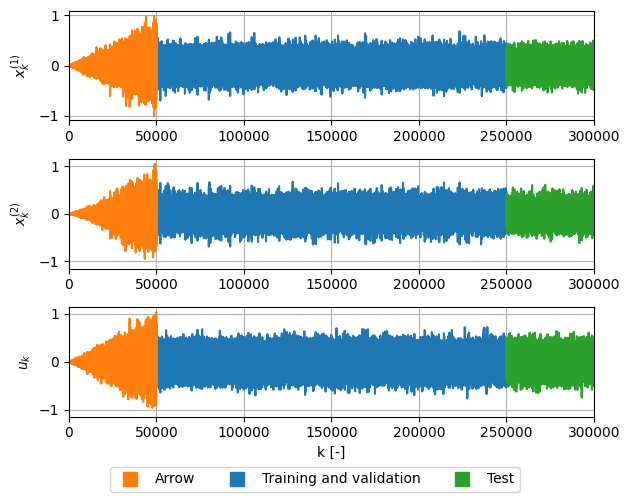

In [9]:
nprint = x_sc.shape[0]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Plot on each subplot
ax1.plot(np.arange(N_arrow,N_arrow+N_train,1),x_sc[N_arrow:N_arrow+N_train,0])         # train
ax1.plot(np.arange(0,N_arrow,1),x_sc[:N_arrow,0])                                      # arrow
ax1.plot(np.arange(N_arrow+N_train,nprint,1),x_sc[-N_test:,0])                         # test
ax1.set_ylabel("$x^{(1)}_{k}$")
ax1.set_xlim([0, nprint])
ax1.set_ylim([-np.max([np.min(x_sc[:,0]), np.max(x_sc[:,0])])-.1, np.max([np.min(x_sc[:,0]), np.max(x_sc[:,0])])+.1])
ax1.grid()

ax2.plot(np.arange(N_arrow,N_arrow+N_train,1),x_sc[N_arrow:N_arrow+N_train,1])         # train
ax2.plot(np.arange(0,N_arrow,1),x_sc[:N_arrow,1])                                      # arrow
ax2.plot(np.arange(N_arrow+N_train,nprint,1),x_sc[-N_test:,1])                         # test
ax2.set_ylabel("$x^{(2)}_{k}$")
ax2.set_xlim([0, nprint])
ax2.set_ylim([-np.max([np.min(x_sc[:,1]), np.max(x_sc[:,1])])-.1, np.max([np.min(x_sc[:,1]), np.max(x_sc[:,1])])+.1])
ax2.grid()

ax3.plot(np.arange(N_arrow,N_arrow+N_train,1),u_sc[N_arrow:N_arrow+N_train])         # train
ax3.plot(np.arange(0,N_arrow,1),u_sc[:N_arrow])                                      # arrow
ax3.plot(np.arange(N_arrow+N_train,nprint,1),u_sc[-N_test:])                         # test
ax3.set_ylabel("$u_{k}$")
ax3.set_xlim([0, nprint])
ax3.set_ylim([-np.max([np.min(u_sc), np.max(u_sc)])-.1, np.max([np.min(u_sc), np.max(u_sc)])+.1])
ax3.set_xlabel("k [-]")
ax3.grid()

# Adjust layout (optional)
plt.tight_layout()

custom_lines = [
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='None', markersize=10, label='Arrow'),
    Line2D([0], [0], color='#1f77b4', marker='s', linestyle='None', markersize=10, label='Training and validation'),
    Line2D([0], [0], color='#2ca02c', marker='s', linestyle='None', markersize=10, label='Test')
]

# Add a single legend below all subplots with colored squares
fig.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)


# plt.savefig('scaled_data.png', dpi=450, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()

In [10]:
# check if solveable with LSQ
input = x_sc[50000:-1,:]
output = x_sc[50001:,:]

u_input = u_sc[50000:-1]
Theta = np.c_[input[:,0], input[:,1], u_input, np.sin(1/T[0,0]*input[:,0])]
# Theta = np.c_[input[:,0], input[:,1], u_input, input[:,0]**2]

sc_coeff, _, _, _ = lin.lstsq(Theta, output)
print("LSTSQ: \n{}\n\ntrue coeff: {}\n".format(sc_coeff, th))

_, s, _ = lin.svd(Theta[60000:70000,:])
print("eigval: {}\n".format(s))

labels = ["x_0[k]","x_1[k]","u_0[k]","sin(x_0[k])"]
eq_sc = display_equation(sc_coeff.flatten("F"), labels, threshold=0.01, precision=6)

LSTSQ: 
[[ 1.00000000e+00 -6.56887213e-01]
 [ 7.61165677e-01  2.50000000e-01]
 [-4.20670443e-17  5.50528724e-01]
 [ 2.22044605e-16  5.49945572e-02]]

true coeff: [-2.  -1.5  2.5  1.5]

eigval: [70.16240263 16.53848193 11.97698655  7.49132797]

x0[k+1] = 1.0*x_0[k]+0.761166*x_1[k]
x1[k+1] = -0.656887*x_0[k]+0.25*x_1[k]+0.550529*u_0[k]+0.054995*sin(x_0[k])


*****GENERATE NOISE SEQUENCE*****

In [11]:
# noise only in trainval section
x_us_arrow, x_us_trainval, x_us_test    = x_us[:N_arrow], x_us[N_arrow:-N_test], x_us[-N_test:]
x_sc_arrow, x_sc_trainval, x_sc_test    = x_sc[:N_arrow], x_sc[N_arrow:-N_test], x_sc[-N_test:]

# adding the noise
snr_dB = 20

_, us_noise_seq = add_gaussian_noise(x_us_trainval, snr_dB)
x_us_noisy = x_us_trainval+us_noise_seq

_, sc_noise_seq = add_gaussian_noise(x_sc_trainval, snr_dB)
x_sc_noisy = x_sc_trainval+sc_noise_seq

# recombining
x_us_noisy = np.r_[x_us_arrow, x_us_noisy, x_us_test]
x_sc_noisy = np.r_[x_sc_arrow, x_sc_noisy, x_sc_test]

snr_linear = 10**(snr_dB / 10)
noise_variance = 1.0 / snr_linear
print(f"Theoretical limit accuracy: {noise_variance}")

Theoretical limit accuracy: 0.01


*****SAVING DATA - CLEAN*****

In [12]:
# save_data( "us_arrow_clean", u_us, x_us, Ts, eq_us, set_idx=[N_arrow, N_train, N_val, N_test])
# save_data( "sc_arrow_clean", u_sc, x_sc, Ts, eq_sc, set_idx=[N_arrow, N_train, N_val, N_test], T=T, sU=U)

*****SAVING DATA - NOISY*****

In [13]:
# save_data( "us_arrow_noisy", u_us, x_us_noisy, Ts, eq_us, set_idx=[N_arrow, N_train, N_val, N_test])
# save_data( "sc_arrow_noisy", u_sc, x_sc_noisy, Ts, eq_sc, set_idx=[N_arrow, N_train, N_val, N_test], T=T, sU=U)